In [1]:
import numpy as np
import xarray as xr
import glob
from datetime import timedelta

import matplotlib.pyplot as plt
%matplotlib inline

print('numpy version  : ', np.__version__)
print('xarray version : ', xr.__version__)

numpy version  :  1.21.2
xarray version :  2022.6.0


In [2]:
zarrdir = '/scratch/cimes/jt7058/data/zarr/'
outdir='/scratch/cimes/jt7058/data/interim/'
var = 'zostoga'
frq = 'monthly'

In [3]:
ddict = {mod:{} for mod in ['CM4_c192_OM4p25','CM4_c192_OM4p125','CM4']}
ddict_exp = {exp:{} for exp in ['piControl_v7','piControl_v8','historical','ssp585']}

for i, mod in enumerate(ddict):
    for j, exp in enumerate(ddict_exp):
        
        if exp.split('_')[0]=='piControl':
            if len(mod.split('_'))>1:
                head = 'CM4_%s_c192_%s_%s'%(exp.split('_')[0],mod.split('_')[-1],exp.split('_')[1])
            else:
                head = 'CM4_%s_C'%exp.split('_')[0]
        else:
            if len(mod.split('_'))>1:
                head = 'CM4_%s_c192_%s'%(exp,mod.split('_')[-1])
            else:
                head = 'CM4_%s_251'%exp
            
        print(head)
        
        var_zarr = 'tos' if exp.split('_')[-1]=='v7' else 'zos'
        zarrs = glob.glob(zarrdir+'%s_global_*_%s_%s'%(head, var_zarr, frq)\
                          +('_d2' if mod.split('_')[-1]=='OM4p125' else ''))
        if len(zarrs)>1:
            print('WARNING: More than one zarr directory for '+head)
        elif len(zarrs)==0:
            print('ERROR: No zarr directory for '+head)
            ddict_exp[exp] = []
            continue
            
        print('Loading '+zarrs[0])
        ds = xr.open_zarr(zarrs[0],use_cftime=True)
        
        dset = 'zostoga_%s'%frq if exp=='historical' else 'zostoga_ref_%s'%frq
        dset = dset+('_d2' if mod.split('_')[-1]=='OM4p125' else '')
        files = glob.glob(outdir+head+'_global_*_'+dset+'.nc')
        if len(files)>1:
            print('WARNING: More than one file for '+dset+' in '+head)
        elif len(files)==0:
            print('ERROR: No file available for '+dset+' in '+head)
            ddict_exp[exp] = []
            continue
            
        print('Loading '+files[0])
        ds[var] = xr.open_dataset(files[0])[var]
        
        if exp.split('_')[0]=='piControl':
            yr_st_cntr = 251 if mod=='CM4' else 101
            yr_st_hist = 1850
            nyrs_shift = yr_st_hist-yr_st_cntr
            print('Shift time axis by',nyrs_shift,'years')
            ds['time'] = ds.time + timedelta(days=365*nyrs_shift)
        
        ddict_exp[exp] = ds

    #print(mod)
    #ddict[mod] = ddict_exp
    ddict[mod] = ddict_exp.copy()

CM4_piControl_c192_OM4p25_v7
Loading /scratch/cimes/jt7058/data/zarr/CM4_piControl_c192_OM4p25_v7_global_0001to0350_tos_monthly
Loading /scratch/cimes/jt7058/data/interim/CM4_piControl_c192_OM4p25_v7_global_0001to0350_zostoga_ref_monthly.nc
Shift time axis by 1749 years
CM4_piControl_c192_OM4p25_v8
Loading /scratch/cimes/jt7058/data/zarr/CM4_piControl_c192_OM4p25_v8_global_0101to0350_zos_monthly
Loading /scratch/cimes/jt7058/data/interim/CM4_piControl_c192_OM4p25_v8_global_0101to0350_zostoga_ref_monthly.nc
Shift time axis by 1749 years
CM4_historical_c192_OM4p25
Loading /scratch/cimes/jt7058/data/zarr/CM4_historical_c192_OM4p25_global_1850to2014_zos_monthly
Loading /scratch/cimes/jt7058/data/interim/CM4_historical_c192_OM4p25_global_1850to2014_zostoga_monthly.nc
CM4_ssp585_c192_OM4p25
Loading /scratch/cimes/jt7058/data/zarr/CM4_ssp585_c192_OM4p25_global_2015to2099_zos_monthly
Loading /scratch/cimes/jt7058/data/interim/CM4_ssp585_c192_OM4p25_global_2015to2099_zostoga_ref_monthly.nc
CM4_

In [4]:
varnames = [var,'dt']
ddict_plot = {}
ddict_plot['CM4Xp25_piControl'] = xr.concat([ddict['CM4_c192_OM4p25']['piControl_v7'].sel(time=slice(None, '1849'))[varnames],
                               ddict['CM4_c192_OM4p25']['piControl_v8'][varnames]], dim='time')

ddict_plot['CM4Xp25_hist_ssp'] = xr.concat([ddict['CM4_c192_OM4p25']['historical'][varnames], 
                              ddict['CM4_c192_OM4p25']['ssp585'][varnames]], dim='time')
ddict_plot['CM4Xp125_piControl'] = ddict['CM4_c192_OM4p125']['piControl_v7'][varnames]
ddict_plot['CM4Xp125_hist_ssp'] = xr.concat([ddict['CM4_c192_OM4p125']['historical'][varnames], 
                               ddict['CM4_c192_OM4p125']['ssp585'][varnames]], dim='time')
ddict_plot['CM4_piControl'] = ddict['CM4']['piControl_v8'][varnames]#.sel(time=slice('1750','2100'))
ddict_plot['CM4_hist_ssp'] = xr.concat([ddict['CM4']['historical'][varnames], 
                               ddict['CM4']['ssp585'][varnames]], dim='time')

In [ ]:
dirstix = '/home/jt7058/stixfonts-master/fonts/static_ttf'
import matplotlib.font_manager as font_manager
for font in font_manager.findSystemFonts(dirstix):
    font_manager.fontManager.addfont(font)

# Set font family globally
plt.rcParams['font.family'] = 'STIX Two Text'

In [12]:
cstr = ['green', 'black', 'blue', 'brown', 'orange', 'red']
lstr = ['CM4X-p25 piControl', 'CM4X-p25 hist + SSP5-8.5', 'CM4X-p125 piControl', 'CM4X-p125 hist + SSP5-8.5',
        'CM4.0 piControl', 'CM4.0 hist + SSP5-8.5']

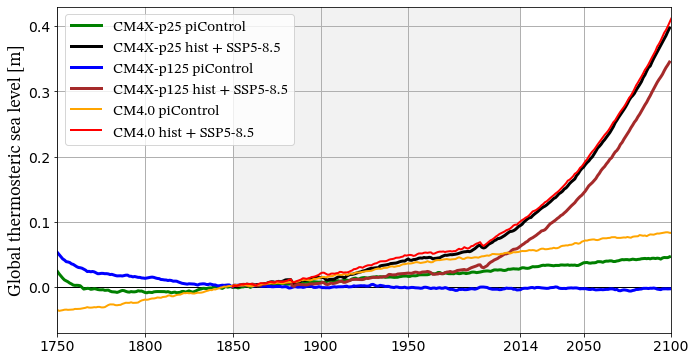

In [18]:
fig, ax = plt.subplots(figsize=(11,6))
ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
for i, name in enumerate(ddict_plot):
    #print(name.split('_')[0])
    da = ddict_plot[name][var]
    da_anm = (da*ddict_plot[name].dt).groupby('time.year').sum('time')\
                /ddict_plot[name].dt.groupby('time.year').sum('time')
    
    da_anm.plot(ax=ax, c=cstr[i], ls = '-', lw=2 if name.split('_')[0]=='CM4' else 3,
                _labels=False, label=lstr[i])
    
ax.set_xlim(1750,2100)
ax.set_xticks(ticks=[1750, 1800, 1850, 1900, 1950, 2014, 2050, 2100])
ax.legend(loc='upper left', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_ylabel('Global thermosteric sea level [m]', fontsize=18)
ax.grid(linewidth=1)

#yrs = da_anm.year.values
#ax.fill_between(yrs, 0, 2, where=(yrs >= 1850) & (yrs <= 2014),interpolate=True, color='gray', alpha=0.1)
ax.set_ylim(-0.07,0.43)
ylimit = ax.get_ylim()
ax.fill([1850,2014,2014,1850],[ylimit[0]-1,ylimit[0]-1,ylimit[1]+0.2,ylimit[1]+0.2],
        'grey', alpha=0.1, edgecolor='None')

plt.savefig('/home/jt7058/figure.png', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', format='png',transparent=False, bbox_inches='tight', pad_inches=0.1)
plt.show()